<a href="https://colab.research.google.com/github/dhilligo/PHYS633S22/blob/main/Hilligoss_Dylan_16_GreyAtmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L16 Grey Atmosphere

We start by importing the modules
* Numpy -- operations on arrays and matrixes (and pi)
* Matplotlib pyplot -- plotting library
* Matplotlin patches -- module that enables patches in plots
* Astropy units -- defined quantities with units. We also import the CDS conversions
* **Scipy special** -- enable the use of the exponential integral function
* **Astropy convolution** -- we will use this to smooth the spectrum of the sun

In [101]:
import numpy as np, copy
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling.models import BlackBody
from astropy import constants as const
import astropy.units as u
from astropy.units import cds
cds.enable() 

from scipy.special import expn
from astropy.convolution import convolve, Box1DKernel

## 1. In class: Temperature structure of the Sun

Here, I provide a file containing (among other things) the temperature structure of the atmosphere of the sun resulting from a detailed model of the Sun's atmosphere (numerical solution involving all 9 equations).

We will compare this to the analytical estimate we obtained by making the approximation that the opacity ($\kappa$) is "grey" (not dependent on wavelength). We also had to use one equation resulting from making a further approximation that the optical depth ($\tau$) is large. 

So let's see how good/bad this approximation actually is!

> **TODO**: In the text below, please write down the equation you are using for $T(\tau)$ in latex format.

***ANSWER***: $$T^4(\tau_{z})=\frac{3T_{eff}^4}{4}(\tau_z+q(\tau_z))$$

> **TODO**: In the graph below, add a curve that shows the approximation for $T(\tau)$ assuming that the correction factor $q(\tau)=0.7104 - 0.133\mathrm{e}^{-3.4488\tau_z}$, why is the numerical value found by using the equation for $\tilde{J}$ (in class last week). 

> **TODO**: In the graph below, add a curve that shows the approximation for $T(\tau)$ assuming that the correction factor $q(\tau)\sim \frac{2}{3}.$

> **TODO**: don't forget to add axis labels and a legend to your graph.

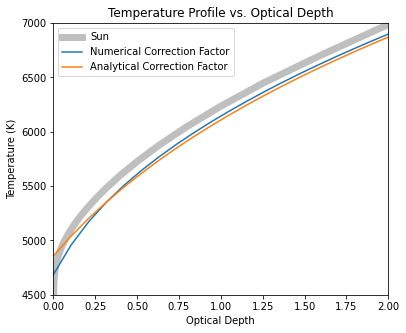

In [102]:
file_url = "https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L16-GreyAtmospheres/16-sun_model.txt"
data = np.genfromtxt(file_url, skip_header=24, skip_footer=229, usecols=(1,2,4), names=True)

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.set_xlim(0,2)
ax.set_ylim(4500,7000)

ax.plot(10**data['lgTauR'], data['T'], label='Sun', lw=7, c="0.75")

#---------------------------------------
#---------------------------------------
# In class

# Define the effective temperature used for the solar model
Teff = 5777.0
tauz=np.linspace(0,2,20)
q=0.7104-0.133*np.exp(-3.4488*tauz)
q1=(2/3)
Temp=((3*Teff**4)/4*(tauz+q))**(1/4)
Temp1=((3*Teff**4)/4*(tauz+q1))**(1/4)

#------------------------
#------------------------
ax.plot(tauz,Temp,label="Numerical Correction Factor")
ax.plot(tauz,Temp1,label="Analytical Correction Factor")
ax.set_xlabel("Optical Depth")
ax.set_ylabel("Temperature (K)")
ax.set_title("Temperature Profile vs. Optical Depth")
ax.legend(loc=0)

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

***ANSWER***: In the above plot, I show the temperature profile as a function of optical depth. The plot contains a curve where we analytically solved for the correction factor *q* as well as another curve where we numerically solved for the correction factor. These two curves are compared to provided model solar data. As one can see, both the analytical and numerical estimates align quite closely to the model. As optical depth increases, so also does the temperature. This increase in temperature due to an increase in optical depth results from solving the Schwarzchild-Milnes equations. Intuitively, as one moves to higher optical depths, or deeper into the star, one would expect the temperature to rise as well.

## 2. Provided function: Calculation of the $C(\alpha, \tau)$ function

We can express the specific flux in a grey atmophere as 
$$F_\alpha(\tau) = \frac{4\pi k^4T_\mathrm{eff}^4}{c^2 h^3} \alpha^3 \left[ \int_{\tau'=\tau}^\infty \frac{E_2(t-\tau)d\tau'}{e^{\alpha p(\tau')}-1} - \int_{\tau'=0}^\tau \frac{E_2(\tau-\tau')d\tau'}{e^{\alpha p(\tau')}-1} \right],$$
where the term in brackets is $C(\alpha, \tau)$, and $\alpha=hc/\lambda kT_\mathrm{eff}$ and $p(\tau)=T_\mathrm{eff}/T(\tau)$. 

The function below accepts a single value of $\alpha$ and a single value of $\tau$. It returns the value of $C(\alpha, \tau)$ **(The quantity in brackets)**.

In [103]:
def p_function(tau):
    
    q = 0.7104 - 0.133*np.exp(-1*3.4488*tau)
    p = 1.0 / ( 0.75 * (tau + q))**0.25
    return(p)

def c_function(alpha, tau):
    
    # create values of t for the integration
    tau_prime_low = np.linspace(0,tau, 1000)
    tau_prime_high = np.linspace(tau, 20, 1000)
    
    # Do the first integral
    y = expn(2, tau_prime_high - tau) / ( np.exp( p_function(tau_prime_high) * alpha)-1 )

    int_high = np.trapz( y, tau_prime_high)
    
    y = expn(2, tau - tau_prime_low) / (np.exp( p_function(tau_prime_low) * alpha)-1 )
    int_low = np.trapz( y, tau_prime_low)
    
    C = int_high - int_low
    
    return(C)


## 3. Let's compare the grey flux with the real solar flux

In the plot below, I give you a solar spectrum, calculated with detailed stellar atmosphere models. The wavelength axis is in nm, and the units of flux are erg/s/cm2/nm. 

> **TODO**: a. In the class worksheet, we found that $F_\alpha / \tilde{F}$ can be expressed as
$$ \frac{F_\alpha(\tau)}{\tilde{F}} = \frac{30}{\pi^4} \alpha^3 C(\alpha, \tau).$$
>
> Use the function provided above for $C(\alpha, \tau)$ above to calculate and plot the flux predicted by the Grey atmosphere model. Note: I highly suggests that you make use of the astropy unit and constant packages. Note that when passing an $\alpha$ to the `c_function(alpha, tau)`, make sure to `alpha.decompose()` and then pass alpha.value to the function.  
>
>Make sure to interpret the result in the interpretation box.

> **TODO**: b. You certainly used $\tau=0$ to calculate the observed spectra. However our grey model allows us to calculate the flux at any optical depth. Add curves for tau = 0.5, 1, and 1.5. Make sure to interpret the result in the interpretation box.


> **TODO** c. When we made an approximation of a linear source function (e.g. when we looked at Limb-darkening), we found that $ F_\lambda(\tau_\lambda=0) \sim \pi S_\lambda(\tau_\lambda=2/3)$.
Using our expression for the grey temperature structure of the atmosphere, find $T(\tau=2/3)$, and using $S_\lambda = B_\lambda$, add a curve for the predicted observed $F_\lambda$ in this approximation. Is it better or worse than our grey atmosphere calculation?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


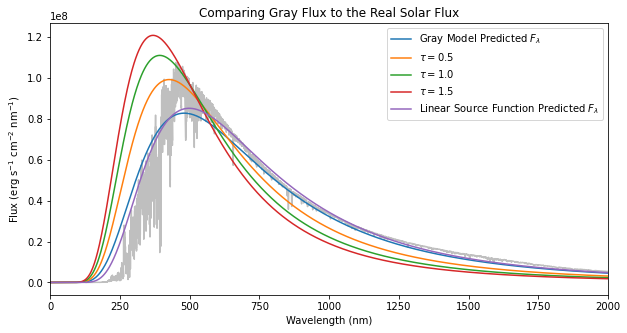

In [104]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_xlim(0,2000)
ax.set_title('Comparing Gray Flux to the Real Solar Flux')
ax.set_ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$)')
ax.set_xlabel('Wavelength (nm)')

# Loading a solar flux model from the MARCS stellar atmosphere models
file_url="https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L16-GreyAtmospheres/16-sun_wave.txt"
wave_sun = np.genfromtxt(file_url)
wave_sun = wave_sun/10*u.nm # Change the wavelength in nm

file_url="https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L16-GreyAtmospheres/16-sun_flux.txt"
flux_sun = np.genfromtxt(file_url)
flux_sun = flux_sun * u.erg/u.s/u.cm**2/u.nm * 10 # * 10 to go from /A to /nm.

ax.plot( wave_sun, convolve(flux_sun, Box1DKernel(31)), c="0.75" )


#--------------------------------
# At home

Teff = 5777*u.K # This is the effective temperature of the model

# I am giving your an array of wavelenght in nm to get you started.
wave = np.linspace(1,2000, 1000)*u.nm 

# I suggest the following procedure:
# 1. find the alpha corresponding to the wavelength
alpha=(const.h*const.c)/(wave*const.k_B*Teff)
#print(alpha)
alpha=alpha.decompose()
# 2. find F_alpha/F (you'll need a loop, as the 
#    c_function(alpha, tau) does not accept arrays.
#print(alpha.size)
Fa_F0=np.zeros(1000)
Fa_F1=np.zeros(1000)
Fa_F2=np.zeros(1000)
Fa_F3=np.zeros(1000)
#print(alpha[0].value)
for item in range(alpha.size):
  Fa_F0[item]=(30*alpha[item]**3*c_function(alpha.value[item],0))/(np.pi**4)
  Fa_F1[item]=(30*alpha[item]**3*c_function(alpha.value[item],0.5))/(np.pi**4)
  Fa_F2[item]=(30*alpha[item]**3*c_function(alpha.value[item],1.0))/(np.pi**4)
  Fa_F3[item]=(30*alpha[item]**3*c_function(alpha.value[item],1.5))/(np.pi**4)
#print(Fa_F1)
# 3. convert F_alpha/F to F_lambda/F :)
Flambda_F0=Fa_F0*((alpha**2*const.k_B*Teff)/(const.h*const.c))
Flambda_F1=Fa_F1*((alpha**2*const.k_B*Teff)/(const.h*const.c))
Flambda_F2=Fa_F2*((alpha**2*const.k_B*Teff)/(const.h*const.c))
Flambda_F3=Fa_F3*((alpha**2*const.k_B*Teff)/(const.h*const.c))
# 4. multiply by F and make sure the units are right
Flambda0=Flambda_F0*(const.sigma_sb*Teff**4)
Flambda1=Flambda_F1*(const.sigma_sb*Teff**4)
Flambda2=Flambda_F2*(const.sigma_sb*Teff**4)
Flambda3=Flambda_F3*(const.sigma_sb*Teff**4)

#print(Flambda1[0])

q2=0.7104-0.133*np.exp(-3.4488*(2/3))
Temp2=((3*Teff**4)/4*((2/3)+q2))**(1/4)
Temp2.to(u.K)

bb=((2)*const.h*(const.c)**2)/(wave**5)*(1/(np.exp(((const.h*const.c))/(wave*const.k_B*Temp2))-1))
flux=bb*np.pi
#------------------------
ax.plot(wave, Flambda0.to(u.erg/(u.s*u.cm**2*u.nm)),label=r'Gray Model Predicted $F_{\lambda}$')
ax.plot(wave, Flambda1.to(u.erg/(u.s*u.cm**2*u.nm)),label=r'$\tau=0.5$')
ax.plot(wave, Flambda2.to(u.erg/(u.s*u.cm**2*u.nm)),label=r'$\tau=1.0$')
ax.plot(wave, Flambda3.to(u.erg/(u.s*u.cm**2*u.nm)),label=r'$\tau=1.5$')
ax.plot(wave,flux.to(u.erg/(u.s*u.cm**2*u.nm)),label=r'Linear Source Function Predicted $F_{\lambda}$')
ax.legend(loc='best')

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

***ANSWER***: In the above graph, we compare gray flux models to the real solar flux obtained from MARCS. The plot contains a number of curves. The blue curve represents the gray model predicted flux (when optical depth is equal to zero). The orange, green, and red curves are gray model fluxes for various optical depths. The purple curve represents the predicted flux when we make the approximation of a linear source function. As one can see, the all the curves align somewhat well with the predicted MARCS model. Higher optical depths will lead to taller peaks in the flux.

When comparing the gray model predicted flux and the linear source function predicted flux, they seem quite similar. However, I would speculate that the flux with the linear source function approximation is slightly better than its counterpart. This is because, by examining the above plot, one can see that the purple curve lines up closer to the MARCS model (the peak is slightly higher and shifted a bit to the right). In general though, they are both decent approximations to the real solar flux.

> **TODO**: <font color='red'>Please write a small reflection on what you have learned and why, since out last notebook. </font>
> 
> Suggestions: how does this notebook provide practice for the learning goal of the last few lectures? how does this topic fits within the learning goals of this course (could be science and/or techniques!), and how does it relates to other things that you have learned in other courses? 

***ANSWER***: I found this notebook to be quite useful in understanding Gray Atmosphere models. The in-class worksheet especially aided in solidifying my understanding of how to derive and calculate gray flux no longer as a direct function of optical depth.
This notebook provides a good visualization of material covered over the last few lectures since previously, most of the work has been math-heavy. This provided me with a good way to see and interpret the various fluxes we derived. This notebook also helped me brush up on some of my coding skills (especially using for loops and the implementation of the Astropy Constants package).